In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/handwritten-persian-numerals/train.csv
/kaggle/input/handwritten-persian-numerals/test.csv


# **1- Importing Required Libraries**

In [2]:
import os
from PIL import Image
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.manifold import TSNE
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR

# **2- Loading Handwritten Persian numerals dataset**

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('float32').reshape(1,28, 28)
        label = self.data.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
train_dataset = MNISTDataset('/kaggle/input/handwritten-persian-numerals/train.csv')
test_dataset = MNISTDataset('/kaggle/input/handwritten-persian-numerals/test.csv')

In [5]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

# **3- Images as Sequences**

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Convert an image into a set of vectors
<hr style="color: red;">
</font>
</div>

In [6]:
def img_to_patch(x, patch_size, flatten_channels=True):

    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [7]:
it=iter(test_loader)
image=next(it)[0]

In [8]:
B, C, H, W = image.shape
print("batch size: {}, number of channels: {}, height: {},  width: {}".format( B, C, H, W ))

batch size: 100, number of channels: 1, height: 28,  width: 28


In [9]:
image[0][0].shape

torch.Size([28, 28])

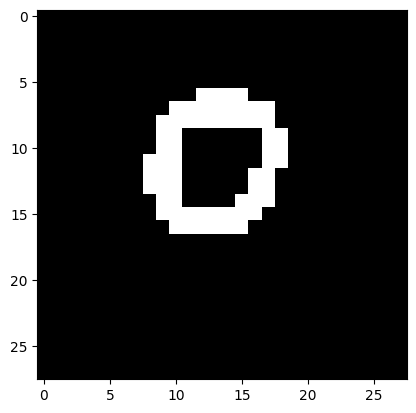

In [10]:
plt.imshow(image[0][0].numpy(),cmap="gray")
plt.show()

In [11]:
patch_size=4

n_patches=(H/patch_size)* (W/patch_size)
n_patches

49.0

In [12]:
patches=img_to_patch(torch.unsqueeze(torch.from_numpy(test_dataset[2][0]),0), patch_size, flatten_channels=False)

In [13]:
patches.shape

torch.Size([1, 49, 1, 4, 4])

# **4- Constructing Vision Transformer Model**

In [14]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
            #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [15]:
class VisionTransformer(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
             #source:https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
        self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
        print(num_patches)


    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)
        B, T, _ = x.shape
        x = self.input_layer(x)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = x + self.pos_embedding[:,:T+1]

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        x = self.transformer(x)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Train Model
<hr style="color: red;">
</font>
</div>

In [16]:
embed_dim= 256
hidden_dim=512
num_heads= 8
num_layers=6
patch_size=4
num_channels=1
num_patches=64
num_classes=10
dropout=0.2

In [17]:
model=VisionTransformer( embed_dim= embed_dim, 
                        hidden_dim=hidden_dim, 
                        num_channels=num_channels, 
                        num_heads=num_heads, 
                        num_layers=num_layers, 
                        num_classes=num_classes, 
                        patch_size=patch_size, 
                        num_patches=num_patches, 
                        dropout=dropout)

64


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
device

device(type='cpu')

In [19]:
lr=3e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [20]:
useful_stuff = {'training_loss': [], 'validation_accuracy': []}
correct_old=0

for epoch in tqdm(range(100)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model.train()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    scheduler.step()
    useful_stuff['training_loss'].append(running_loss)
    correct = 0
    model.eval()

    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      z = model(inputs)
      _, yhat = torch.max(z, 1)
      correct += (yhat == labels).sum().item()
      if correct>correct_old:
          correct_old=correct

    useful_stuff['validation_accuracy'].append(correct_old/len(test_dataset))
print('Finished Training')

100%|██████████| 100/100 [43:18<00:00, 25.99s/it]

Finished Training


<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Save our model parameters
<hr style="color: red;">
</font>
</div>

In [21]:
torch.save(model.state_dict(), "/kaggle/working/Persian_HandWritten_with_pytorch_model.pth")
print("Saved PyTorch Model State to Persian_HandWritten_with_pytorch_model.pth")

Saved PyTorch Model State to Persian_HandWritten_with_pytorch_model.pth


In [22]:
model.load_state_dict(torch.load('/kaggle/working/Persian_HandWritten_with_pytorch_model.pth',map_location=device))
model.eval()

/tmp/ipykernel_17/483530030.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/Persian_HandWritten_with_pytorch_model.pth'

VisionTransformer(
  (input_layer): Linear(in_features=16, out_features=256, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=512, out_features=256, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): Layer

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Output for the model
<hr style="color: red;">
</font>
</div>

In [23]:
it=iter(test_loader)
images, labels= next(it)

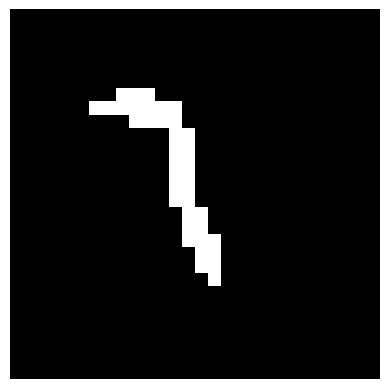

Predicted label: tensor(6)
Actual label: tensor(6)
Probabilities:
Class 0: 0.00014854663459118456
Class 1: 0.000752699445001781
Class 2: 0.0026101248804479837
Class 3: 0.00022546992113348097
Class 4: 0.009277704171836376
Class 5: 7.372790423687547e-05
Class 6: 0.8671817183494568
Class 7: 0.0027714029420167208
Class 8: 0.00039898266550153494
Class 9: 0.11655955761671066



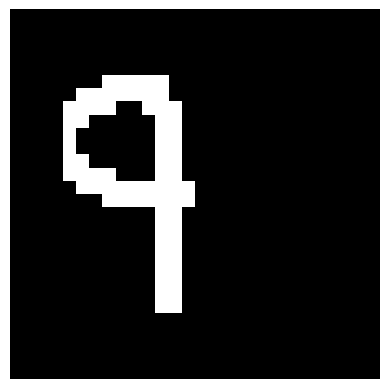

Predicted label: tensor(9)
Actual label: tensor(9)
Probabilities:
Class 0: 0.0043771229684352875
Class 1: 2.3048269213177264e-05
Class 2: 0.00018960119632538408
Class 3: 0.0015670319553464651
Class 4: 0.00551589485257864
Class 5: 0.002199710113927722
Class 6: 0.01865307427942753
Class 7: 7.137825014069676e-05
Class 8: 0.0002202346659032628
Class 9: 0.9671828746795654



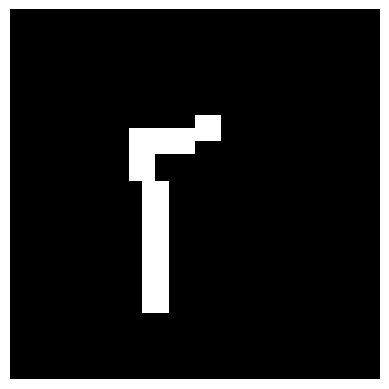

Predicted label: tensor(3)
Actual label: tensor(2)
Probabilities:
Class 0: 0.004588960204273462
Class 1: 0.0028060676995664835
Class 2: 0.07635914534330368
Class 3: 0.6012097597122192
Class 4: 0.04239343851804733
Class 5: 0.00014073635975364596
Class 6: 0.24431098997592926
Class 7: 0.027075132355093956
Class 8: 0.00041348603554069996
Class 9: 0.0007022327627055347



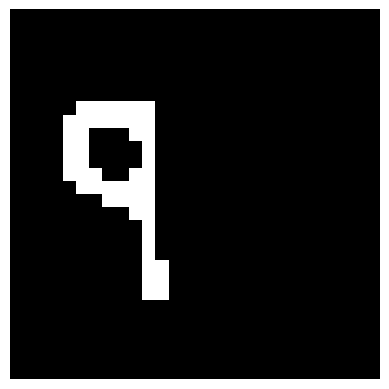

Predicted label: tensor(9)
Actual label: tensor(9)
Probabilities:
Class 0: 0.005122299771755934
Class 1: 0.0003562307683750987
Class 2: 0.018213219940662384
Class 3: 0.022344430908560753
Class 4: 0.29278919100761414
Class 5: 0.030298318713903427
Class 6: 0.15150268375873566
Class 7: 0.05829143524169922
Class 8: 6.587005191249773e-05
Class 9: 0.4210163354873657



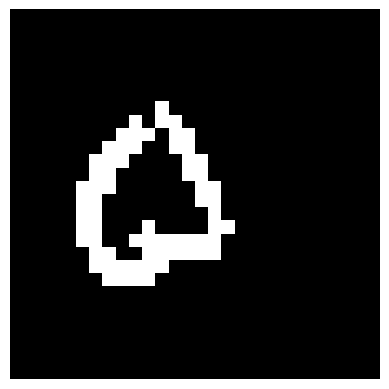

Predicted label: tensor(5)
Actual label: tensor(5)
Probabilities:
Class 0: 0.17925585806369781
Class 1: 4.016089951619506e-05
Class 2: 1.9056868040934205e-05
Class 3: 0.00019991428416687995
Class 4: 0.0015432076761499047
Class 5: 0.8164277076721191
Class 6: 0.00036023539723828435
Class 7: 0.0008533551590517163
Class 8: 0.0008065478759817779
Class 9: 0.0004939936334267259



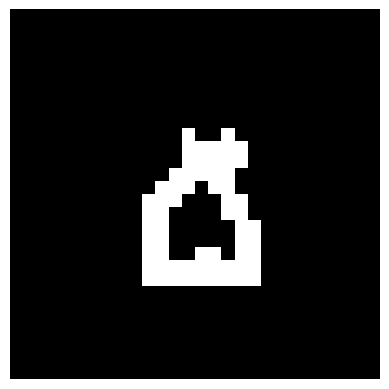

Predicted label: tensor(5)
Actual label: tensor(5)
Probabilities:
Class 0: 0.026806695386767387
Class 1: 4.513720341492444e-05
Class 2: 1.2817567039746791e-05
Class 3: 2.4075055989669636e-05
Class 4: 0.0006038430146872997
Class 5: 0.9686652421951294
Class 6: 0.00021455183741636574
Class 7: 0.002813190221786499
Class 8: 0.0006473169778473675
Class 9: 0.00016710333875380456



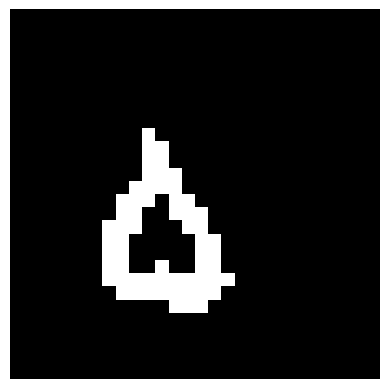

Predicted label: tensor(5)
Actual label: tensor(5)
Probabilities:
Class 0: 0.006830593571066856
Class 1: 0.0001010241758194752
Class 2: 0.0001918294292408973
Class 3: 0.0001849276159191504
Class 4: 0.018866440281271935
Class 5: 0.969372570514679
Class 6: 0.00028863930492661893
Class 7: 0.002793269231915474
Class 8: 0.0013438761234283447
Class 9: 2.6952433472615667e-05



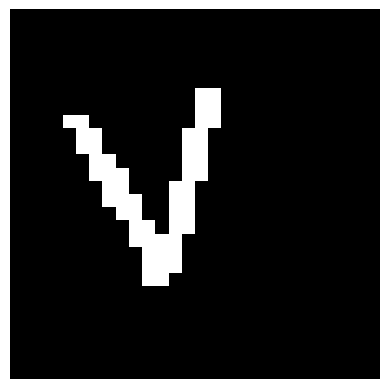

Predicted label: tensor(7)
Actual label: tensor(7)
Probabilities:
Class 0: 0.006626928225159645
Class 1: 0.00011272197298239917
Class 2: 0.00026948278537020087
Class 3: 0.00019694058573804796
Class 4: 0.0020116197410970926
Class 5: 0.014659898355603218
Class 6: 0.0279916450381279
Class 7: 0.9475899338722229
Class 8: 3.576956078177318e-05
Class 9: 0.000505143660120666



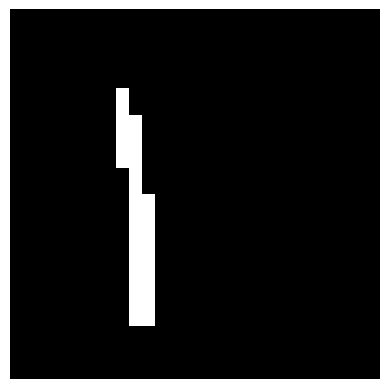

Predicted label: tensor(1)
Actual label: tensor(1)
Probabilities:
Class 0: 0.00034254268393851817
Class 1: 0.9534942507743835
Class 2: 0.04183506593108177
Class 3: 0.0014777452452108264
Class 4: 0.0008713593706488609
Class 5: 2.3448192223440856e-05
Class 6: 0.0010729326168075204
Class 7: 0.0004910569405183196
Class 8: 0.00037390433135442436
Class 9: 1.7754246073309332e-05



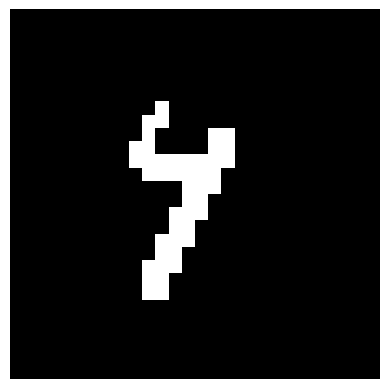

Predicted label: tensor(6)
Actual label: tensor(6)
Probabilities:
Class 0: 0.0017362607177346945
Class 1: 4.926080509903841e-05
Class 2: 0.008387245237827301
Class 3: 0.008139312267303467
Class 4: 0.014121408574283123
Class 5: 0.00043854519026353955
Class 6: 0.9652804732322693
Class 7: 0.0005247084773145616
Class 8: 9.006982872961089e-05
Class 9: 0.0012326918076723814



In [24]:
# Only 3 images are selected
images = images[:10]
labels = labels[:10]

p_yx = model(images)

# Get predicted probabilities
probabilities = F.softmax(p_yx, dim=1)

# Find predicted labels
predicted_labels = probabilities.argmax(dim=1)

# Compare predicted labels with actual labels and display the images
for i in range(len(images)):
    # Convert the image tensor to a numpy array
    image = images[i].squeeze().numpy()

    # Display the image in grayscale
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    print("Predicted label:", predicted_labels[i])
    print("Actual label:", labels[i])
    print("Probabilities:")

    # Print probabilities for each class
    for j in range(len(probabilities[i])):
        class_name = f"Class {j}"
        probability = probabilities[i][j].item()
        print(f"{class_name}: {probability}")

    print()

<div style="background-color: red; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
If my notebook was useful for you, please give me a upvote. Thank you for your support ❤️
    <hr style="color: green;"></font>
    <font size="5px">
         <a href="https://github.com/omid-sakaki-ghazvini">Github</a>
        <br/>
        <a href="http://linkedin.com/in/omid-sakaki-ghazvini-378687217">linkedin</a> 
    </font>
</div>